In [1]:
import os
import re
import math
import glob
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

pygame 2.6.1 (SDL 2.28.4, Python 3.13.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


E:\Projects\osu\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
APP_DATA = os.getenv("APPDATA")
OSU_PATH = f'{APP_DATA}/../Local/osu!'

print(OSU_PATH)

test_map = 'assets/1hope_map.osu'
test_replay = 'assets/1hope_replay.osr'
test_song = 'assets/1hope_song.mp3'

C:\Users\niooi\AppData\Roaming/../Local/osu!


In [3]:
import osu.downloader as downloader

# download only S ranks from top 50 on each map
mapsets = [
    '1263383 Niji no Conquistador - Zutto Summer de Koishiteru [no video]',
    '977552 umu - humanly [no video]',
    '848400 Haywyre - Insight',
    '675779 Camellia - NUCLEAR-STAR'
]
def filter_beatmap(beatmap: bm.Beatmap) -> bool:
    if beatmap.ar_raw() <= 9.6:
        return False
    
    return True

obj_dataset = downloader.download_mapsets(mapsets, filter=filter_beatmap, only='S')

C:\Users\niooi\AppData\Roaming/../Local/osu!
loading Niji no Conquistador - Zutto Summer de Koishiteru (Sotarks) [Akitoshi's Extreme].osu
loading Niji no Conquistador - Zutto Summer de Koishiteru (Sotarks) [ending].osu
loading Niji no Conquistador - Zutto Summer de Koishiteru (Sotarks) [SMOKELIND's Insane].osu
loading Niji no Conquistador - Zutto Summer de Koishiteru (Sotarks) [Summer Love 1.08x (260bpm) OD9.8].osu
loading Niji no Conquistador - Zutto Summer de Koishiteru (Sotarks) [Summer Love].osu
loading umu. - humanly (Half) [cs lololoololo].osu
loading umu. - humanly (Half) [hard].osu
loading umu. - humanly (Half) [humanly].osu
loading umu. - humanly (Half) [Len's Robotically Another].osu
loading umu. - humanly (Half) [Len's Robotically Insane].osu
loading umu. - humanly (Half) [lower cs].osu
loading umu. - humanly (Half) [normal].osu
loading Haywyre - Insight (Twiggykun) [Normal].osu
loading Haywyre - Insight (Twiggykun) [pog].osu
loading Camellia - NUCLEAR-STAR (ProfessionalBox)

In [4]:
obj_dataset

,replay,beatmap
0,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
1,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
3,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
...,...,...
5,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
6,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
7,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
8,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...


In [5]:
input = dataset.input_data(obj_dataset, verbose=True)
output = dataset.target_data(obj_dataset, verbose=True)

201it [00:07, 25.13it/s]
E:\Projects\osu\osu\dataset.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  tensor_list = [torch.tensor(seq, dtype=torch.float) for seq in data]
201it [00:03, 59.73it/s] 


In [6]:
output

x         y
chunk frame                    
0     0      0.022569 -0.057870
      1      0.022569 -0.057870
      2      0.019965 -0.055555
      3      0.016493 -0.054398
      4      0.009549 -0.052083
...               ...       ...
885   2043   0.000000  0.000000
      2044   0.000000  0.000000
      2045   0.000000  0.000000
      2046   0.000000  0.000000
      2047   0.000000  0.000000

[1814528 rows x 2 columns]

In [7]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

ys.shape

(886, 2048, 2)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class OsuModel(nn.Module):
    def __init__(self, input_size, output_size, noise_std=0.2):
        super(OsuModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.dense1 = nn.Linear(64, 64)
        self.noise_std = noise_std
        self.dense2 = nn.Linear(64, 16)
        self.position = nn.Linear(16, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        pos = self.dense1(lstm_out)
        
        # gaussian noise (only applied during training)
        if self.training:
            noise = torch.randn_like(pos) * self.noise_std
            pos = pos + noise
        
        pos = self.dense2(pos)
        pos = self.position(pos)
        
        return pos

input_size = xs.shape[2]  # feature dimension
output_size = ys.shape[2]  # output dimension

model = OsuModel(input_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()  # MAE equivalent

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

OsuModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=16, bias=True)
  (position): Linear(in_features=16, out_features=2, bias=True)
)
Total parameters: 23410


In [9]:
from sklearn.model_selection import train_test_split
from random import randint 
from torch.utils.data import DataLoader, TensorDataset

EPOCHS = 500
BATCH_SIZE = 32

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.3, random_state=randint(0, 100))

train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [10]:
epoch_losses = []

In [11]:
import tqdm

for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_x, batch_y in tqdm.tqdm(train_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        # print(batch_x.shape)
        # print(batch_y.shape)
        optimizer.zero_grad()
        outputs = model(batch_x)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss = epoch_loss/len(train_loader)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}')
    epoch_losses.append(epoch_loss)
    

100%|██████████| 20/20 [00:00<00:00, 68.35it/s]


Epoch 1/500, Loss: 0.1884


100%|██████████| 20/20 [00:00<00:00, 116.36it/s]


Epoch 2/500, Loss: 0.1714


100%|██████████| 20/20 [00:00<00:00, 125.37it/s]


Epoch 3/500, Loss: 0.1518


100%|██████████| 20/20 [00:00<00:00, 117.82it/s]


Epoch 4/500, Loss: 0.1377


100%|██████████| 20/20 [00:00<00:00, 116.12it/s]


Epoch 5/500, Loss: 0.1321


100%|██████████| 20/20 [00:00<00:00, 108.43it/s]


Epoch 6/500, Loss: 0.1266


100%|██████████| 20/20 [00:00<00:00, 95.45it/s]


Epoch 7/500, Loss: 0.1244


100%|██████████| 20/20 [00:00<00:00, 110.97it/s]


Epoch 8/500, Loss: 0.1222


100%|██████████| 20/20 [00:00<00:00, 113.85it/s]


Epoch 9/500, Loss: 0.1214


100%|██████████| 20/20 [00:00<00:00, 114.07it/s]


Epoch 10/500, Loss: 0.1190


100%|██████████| 20/20 [00:00<00:00, 107.32it/s]


Epoch 11/500, Loss: 0.1177


100%|██████████| 20/20 [00:00<00:00, 103.35it/s]


Epoch 12/500, Loss: 0.1188


100%|██████████| 20/20 [00:00<00:00, 109.43it/s]


Epoch 13/500, Loss: 0.1192


100%|██████████| 20/20 [00:00<00:00, 109.50it/s]


Epoch 14/500, Loss: 0.1192


100%|██████████| 20/20 [00:00<00:00, 100.98it/s]


Epoch 15/500, Loss: 0.1175


100%|██████████| 20/20 [00:00<00:00, 101.57it/s]


Epoch 16/500, Loss: 0.1178


100%|██████████| 20/20 [00:00<00:00, 108.28it/s]


Epoch 17/500, Loss: 0.1163


100%|██████████| 20/20 [00:00<00:00, 111.29it/s]


Epoch 18/500, Loss: 0.1166


100%|██████████| 20/20 [00:00<00:00, 101.56it/s]


Epoch 19/500, Loss: 0.1161


100%|██████████| 20/20 [00:00<00:00, 96.42it/s]


Epoch 20/500, Loss: 0.1156


100%|██████████| 20/20 [00:00<00:00, 88.56it/s]


Epoch 21/500, Loss: 0.1178


100%|██████████| 20/20 [00:00<00:00, 111.61it/s]


Epoch 22/500, Loss: 0.1163


100%|██████████| 20/20 [00:00<00:00, 115.19it/s]


Epoch 23/500, Loss: 0.1152


100%|██████████| 20/20 [00:00<00:00, 100.12it/s]


Epoch 24/500, Loss: 0.1156


100%|██████████| 20/20 [00:00<00:00, 91.01it/s]


Epoch 25/500, Loss: 0.1167


100%|██████████| 20/20 [00:00<00:00, 100.87it/s]


Epoch 26/500, Loss: 0.1158


100%|██████████| 20/20 [00:00<00:00, 98.05it/s]


Epoch 27/500, Loss: 0.1159


100%|██████████| 20/20 [00:00<00:00, 97.75it/s]


Epoch 28/500, Loss: 0.1151


100%|██████████| 20/20 [00:00<00:00, 101.02it/s]


Epoch 29/500, Loss: 0.1155


100%|██████████| 20/20 [00:00<00:00, 107.49it/s]


Epoch 30/500, Loss: 0.1150


100%|██████████| 20/20 [00:00<00:00, 103.95it/s]


Epoch 31/500, Loss: 0.1144


100%|██████████| 20/20 [00:00<00:00, 92.49it/s]


Epoch 32/500, Loss: 0.1164


100%|██████████| 20/20 [00:00<00:00, 111.31it/s]


Epoch 33/500, Loss: 0.1148


100%|██████████| 20/20 [00:00<00:00, 103.75it/s]


Epoch 34/500, Loss: 0.1144


100%|██████████| 20/20 [00:00<00:00, 95.92it/s]


Epoch 35/500, Loss: 0.1153


100%|██████████| 20/20 [00:00<00:00, 86.18it/s]


Epoch 36/500, Loss: 0.1159


100%|██████████| 20/20 [00:00<00:00, 103.79it/s]


Epoch 37/500, Loss: 0.1151


100%|██████████| 20/20 [00:00<00:00, 103.19it/s]


Epoch 38/500, Loss: 0.1137


100%|██████████| 20/20 [00:00<00:00, 90.15it/s]


Epoch 39/500, Loss: 0.1159


100%|██████████| 20/20 [00:00<00:00, 96.89it/s]


Epoch 40/500, Loss: 0.1149


100%|██████████| 20/20 [00:00<00:00, 103.08it/s]


Epoch 41/500, Loss: 0.1140


100%|██████████| 20/20 [00:00<00:00, 98.40it/s]


Epoch 42/500, Loss: 0.1156


100%|██████████| 20/20 [00:00<00:00, 99.79it/s]


Epoch 43/500, Loss: 0.1155


100%|██████████| 20/20 [00:00<00:00, 101.16it/s]


Epoch 44/500, Loss: 0.1155


100%|██████████| 20/20 [00:00<00:00, 106.30it/s]


Epoch 45/500, Loss: 0.1138


100%|██████████| 20/20 [00:00<00:00, 104.89it/s]


Epoch 46/500, Loss: 0.1154


100%|██████████| 20/20 [00:00<00:00, 98.14it/s] 


Epoch 47/500, Loss: 0.1129


100%|██████████| 20/20 [00:00<00:00, 102.10it/s]


Epoch 48/500, Loss: 0.1131


100%|██████████| 20/20 [00:00<00:00, 96.12it/s]


Epoch 49/500, Loss: 0.1151


100%|██████████| 20/20 [00:00<00:00, 101.02it/s]


Epoch 50/500, Loss: 0.1139


100%|██████████| 20/20 [00:00<00:00, 102.90it/s]


Epoch 51/500, Loss: 0.1132


100%|██████████| 20/20 [00:00<00:00, 100.07it/s]


Epoch 52/500, Loss: 0.1129


100%|██████████| 20/20 [00:00<00:00, 104.24it/s]


Epoch 53/500, Loss: 0.1150


100%|██████████| 20/20 [00:00<00:00, 101.42it/s]


Epoch 54/500, Loss: 0.1120


100%|██████████| 20/20 [00:00<00:00, 102.79it/s]


Epoch 55/500, Loss: 0.1137


100%|██████████| 20/20 [00:00<00:00, 97.63it/s]


Epoch 56/500, Loss: 0.1145


100%|██████████| 20/20 [00:00<00:00, 101.81it/s]


Epoch 57/500, Loss: 0.1145


100%|██████████| 20/20 [00:00<00:00, 101.07it/s]


Epoch 58/500, Loss: 0.1135


100%|██████████| 20/20 [00:00<00:00, 102.76it/s]


Epoch 59/500, Loss: 0.1146


100%|██████████| 20/20 [00:00<00:00, 101.24it/s]


Epoch 60/500, Loss: 0.1140


100%|██████████| 20/20 [00:00<00:00, 98.96it/s]


Epoch 61/500, Loss: 0.1143


100%|██████████| 20/20 [00:00<00:00, 105.20it/s]


Epoch 62/500, Loss: 0.1123


100%|██████████| 20/20 [00:00<00:00, 101.58it/s]


Epoch 63/500, Loss: 0.1141


100%|██████████| 20/20 [00:00<00:00, 100.36it/s]


Epoch 64/500, Loss: 0.1126


100%|██████████| 20/20 [00:00<00:00, 104.02it/s]


Epoch 65/500, Loss: 0.1126


100%|██████████| 20/20 [00:00<00:00, 101.46it/s]


Epoch 66/500, Loss: 0.1133


100%|██████████| 20/20 [00:00<00:00, 100.89it/s]


Epoch 67/500, Loss: 0.1139


100%|██████████| 20/20 [00:00<00:00, 99.20it/s]


Epoch 68/500, Loss: 0.1136


100%|██████████| 20/20 [00:00<00:00, 97.38it/s]


Epoch 69/500, Loss: 0.1137


100%|██████████| 20/20 [00:00<00:00, 106.26it/s]


Epoch 70/500, Loss: 0.1125


100%|██████████| 20/20 [00:00<00:00, 101.83it/s]


Epoch 71/500, Loss: 0.1131


100%|██████████| 20/20 [00:00<00:00, 101.16it/s]


Epoch 72/500, Loss: 0.1142


100%|██████████| 20/20 [00:00<00:00, 97.97it/s]


Epoch 73/500, Loss: 0.1128


100%|██████████| 20/20 [00:00<00:00, 97.48it/s]


Epoch 74/500, Loss: 0.1122


100%|██████████| 20/20 [00:00<00:00, 98.45it/s] 


Epoch 75/500, Loss: 0.1128


100%|██████████| 20/20 [00:00<00:00, 99.35it/s]


Epoch 76/500, Loss: 0.1131


100%|██████████| 20/20 [00:00<00:00, 102.23it/s]


Epoch 77/500, Loss: 0.1129


100%|██████████| 20/20 [00:00<00:00, 103.00it/s]


Epoch 78/500, Loss: 0.1122


100%|██████████| 20/20 [00:00<00:00, 102.33it/s]


Epoch 79/500, Loss: 0.1128


100%|██████████| 20/20 [00:00<00:00, 100.67it/s]


Epoch 80/500, Loss: 0.1134


100%|██████████| 20/20 [00:00<00:00, 103.17it/s]


Epoch 81/500, Loss: 0.1130


100%|██████████| 20/20 [00:00<00:00, 106.54it/s]


Epoch 82/500, Loss: 0.1123


100%|██████████| 20/20 [00:00<00:00, 100.22it/s]


Epoch 83/500, Loss: 0.1122


100%|██████████| 20/20 [00:00<00:00, 101.20it/s]


Epoch 84/500, Loss: 0.1129


100%|██████████| 20/20 [00:00<00:00, 100.90it/s]


Epoch 85/500, Loss: 0.1132


100%|██████████| 20/20 [00:00<00:00, 104.98it/s]


Epoch 86/500, Loss: 0.1131


100%|██████████| 20/20 [00:00<00:00, 95.40it/s]


Epoch 87/500, Loss: 0.1113


100%|██████████| 20/20 [00:00<00:00, 97.39it/s]


Epoch 88/500, Loss: 0.1121


100%|██████████| 20/20 [00:00<00:00, 97.76it/s]


Epoch 89/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 99.43it/s]


Epoch 90/500, Loss: 0.1135


100%|██████████| 20/20 [00:00<00:00, 100.00it/s]


Epoch 91/500, Loss: 0.1132


100%|██████████| 20/20 [00:00<00:00, 100.39it/s]


Epoch 92/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 103.63it/s]


Epoch 93/500, Loss: 0.1123


100%|██████████| 20/20 [00:00<00:00, 104.61it/s]


Epoch 94/500, Loss: 0.1113


100%|██████████| 20/20 [00:00<00:00, 100.18it/s]


Epoch 95/500, Loss: 0.1113


100%|██████████| 20/20 [00:00<00:00, 99.84it/s] 


Epoch 96/500, Loss: 0.1124


100%|██████████| 20/20 [00:00<00:00, 104.67it/s]


Epoch 97/500, Loss: 0.1117


100%|██████████| 20/20 [00:00<00:00, 101.59it/s]


Epoch 98/500, Loss: 0.1144


100%|██████████| 20/20 [00:00<00:00, 105.07it/s]


Epoch 99/500, Loss: 0.1143


100%|██████████| 20/20 [00:00<00:00, 103.80it/s]


Epoch 100/500, Loss: 0.1142


100%|██████████| 20/20 [00:00<00:00, 103.63it/s]


Epoch 101/500, Loss: 0.1129


100%|██████████| 20/20 [00:00<00:00, 109.45it/s]


Epoch 102/500, Loss: 0.1123


100%|██████████| 20/20 [00:00<00:00, 101.70it/s]


Epoch 103/500, Loss: 0.1112


100%|██████████| 20/20 [00:00<00:00, 103.86it/s]


Epoch 104/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 100.81it/s]


Epoch 105/500, Loss: 0.1117


100%|██████████| 20/20 [00:00<00:00, 104.36it/s]


Epoch 106/500, Loss: 0.1124


100%|██████████| 20/20 [00:00<00:00, 102.26it/s]


Epoch 107/500, Loss: 0.1115


100%|██████████| 20/20 [00:00<00:00, 104.96it/s]


Epoch 108/500, Loss: 0.1123


100%|██████████| 20/20 [00:00<00:00, 102.99it/s]


Epoch 109/500, Loss: 0.1125


100%|██████████| 20/20 [00:00<00:00, 106.74it/s]


Epoch 110/500, Loss: 0.1123


100%|██████████| 20/20 [00:00<00:00, 102.31it/s]


Epoch 111/500, Loss: 0.1104


100%|██████████| 20/20 [00:00<00:00, 103.53it/s]


Epoch 112/500, Loss: 0.1118


100%|██████████| 20/20 [00:00<00:00, 103.44it/s]


Epoch 113/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 102.85it/s]


Epoch 114/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 106.72it/s]


Epoch 115/500, Loss: 0.1124


100%|██████████| 20/20 [00:00<00:00, 102.36it/s]


Epoch 116/500, Loss: 0.1133


100%|██████████| 20/20 [00:00<00:00, 102.27it/s]


Epoch 117/500, Loss: 0.1119


100%|██████████| 20/20 [00:00<00:00, 106.55it/s]


Epoch 118/500, Loss: 0.1101


100%|██████████| 20/20 [00:00<00:00, 103.87it/s]


Epoch 119/500, Loss: 0.1118


100%|██████████| 20/20 [00:00<00:00, 102.00it/s]


Epoch 120/500, Loss: 0.1111


100%|██████████| 20/20 [00:00<00:00, 98.38it/s]


Epoch 121/500, Loss: 0.1115


100%|██████████| 20/20 [00:00<00:00, 103.02it/s]


Epoch 122/500, Loss: 0.1109


100%|██████████| 20/20 [00:00<00:00, 100.83it/s]


Epoch 123/500, Loss: 0.1117


100%|██████████| 20/20 [00:00<00:00, 100.87it/s]


Epoch 124/500, Loss: 0.1125


100%|██████████| 20/20 [00:00<00:00, 101.79it/s]


Epoch 125/500, Loss: 0.1126


100%|██████████| 20/20 [00:00<00:00, 101.17it/s]


Epoch 126/500, Loss: 0.1104


100%|██████████| 20/20 [00:00<00:00, 99.12it/s]


Epoch 127/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 97.63it/s]


Epoch 128/500, Loss: 0.1128


100%|██████████| 20/20 [00:00<00:00, 100.83it/s]


Epoch 129/500, Loss: 0.1118


100%|██████████| 20/20 [00:00<00:00, 102.37it/s]


Epoch 130/500, Loss: 0.1105


100%|██████████| 20/20 [00:00<00:00, 97.75it/s]


Epoch 131/500, Loss: 0.1113


100%|██████████| 20/20 [00:00<00:00, 109.41it/s]


Epoch 132/500, Loss: 0.1117


100%|██████████| 20/20 [00:00<00:00, 97.50it/s]


Epoch 133/500, Loss: 0.1112


100%|██████████| 20/20 [00:00<00:00, 100.58it/s]


Epoch 134/500, Loss: 0.1114


100%|██████████| 20/20 [00:00<00:00, 105.53it/s]


Epoch 135/500, Loss: 0.1111


100%|██████████| 20/20 [00:00<00:00, 101.27it/s]


Epoch 136/500, Loss: 0.1121


100%|██████████| 20/20 [00:00<00:00, 105.40it/s]


Epoch 137/500, Loss: 0.1111


100%|██████████| 20/20 [00:00<00:00, 101.23it/s]


Epoch 138/500, Loss: 0.1123


100%|██████████| 20/20 [00:00<00:00, 99.26it/s]


Epoch 139/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 98.56it/s]


Epoch 140/500, Loss: 0.1117


100%|██████████| 20/20 [00:00<00:00, 95.87it/s]


Epoch 141/500, Loss: 0.1118


100%|██████████| 20/20 [00:00<00:00, 99.60it/s]


Epoch 142/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 98.57it/s]


Epoch 143/500, Loss: 0.1114


100%|██████████| 20/20 [00:00<00:00, 99.53it/s]


Epoch 144/500, Loss: 0.1100


100%|██████████| 20/20 [00:00<00:00, 99.82it/s]


Epoch 145/500, Loss: 0.1120


100%|██████████| 20/20 [00:00<00:00, 87.34it/s]


Epoch 146/500, Loss: 0.1119


100%|██████████| 20/20 [00:00<00:00, 97.04it/s]


Epoch 147/500, Loss: 0.1094


100%|██████████| 20/20 [00:00<00:00, 90.94it/s]


Epoch 148/500, Loss: 0.1114


100%|██████████| 20/20 [00:00<00:00, 86.96it/s]


Epoch 149/500, Loss: 0.1121


100%|██████████| 20/20 [00:00<00:00, 89.89it/s]


Epoch 150/500, Loss: 0.1106


100%|██████████| 20/20 [00:00<00:00, 92.66it/s]


Epoch 151/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 94.30it/s]


Epoch 152/500, Loss: 0.1101


100%|██████████| 20/20 [00:00<00:00, 94.09it/s]


Epoch 153/500, Loss: 0.1114


100%|██████████| 20/20 [00:00<00:00, 84.68it/s]


Epoch 154/500, Loss: 0.1115


100%|██████████| 20/20 [00:00<00:00, 88.04it/s]


Epoch 155/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 91.12it/s]


Epoch 156/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 89.45it/s]


Epoch 157/500, Loss: 0.1115


100%|██████████| 20/20 [00:00<00:00, 84.87it/s]


Epoch 158/500, Loss: 0.1120


100%|██████████| 20/20 [00:00<00:00, 92.12it/s]


Epoch 159/500, Loss: 0.1101


100%|██████████| 20/20 [00:00<00:00, 90.00it/s]


Epoch 160/500, Loss: 0.1097


100%|██████████| 20/20 [00:00<00:00, 100.08it/s]


Epoch 161/500, Loss: 0.1106


100%|██████████| 20/20 [00:00<00:00, 90.84it/s]


Epoch 162/500, Loss: 0.1100


100%|██████████| 20/20 [00:00<00:00, 88.17it/s]


Epoch 163/500, Loss: 0.1126


100%|██████████| 20/20 [00:00<00:00, 98.21it/s]


Epoch 164/500, Loss: 0.1105


100%|██████████| 20/20 [00:00<00:00, 90.22it/s]


Epoch 165/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 89.19it/s]


Epoch 166/500, Loss: 0.1101


100%|██████████| 20/20 [00:00<00:00, 92.00it/s]


Epoch 167/500, Loss: 0.1114


100%|██████████| 20/20 [00:00<00:00, 86.92it/s]


Epoch 168/500, Loss: 0.1114


100%|██████████| 20/20 [00:00<00:00, 101.53it/s]


Epoch 169/500, Loss: 0.1114


100%|██████████| 20/20 [00:00<00:00, 89.73it/s]


Epoch 170/500, Loss: 0.1115


100%|██████████| 20/20 [00:00<00:00, 94.96it/s]


Epoch 171/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 92.67it/s]


Epoch 172/500, Loss: 0.1112


100%|██████████| 20/20 [00:00<00:00, 88.12it/s]


Epoch 173/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 88.27it/s]


Epoch 174/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 87.08it/s]


Epoch 175/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 90.61it/s]


Epoch 176/500, Loss: 0.1102


100%|██████████| 20/20 [00:00<00:00, 84.55it/s]


Epoch 177/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 98.67it/s]


Epoch 178/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 99.62it/s]


Epoch 179/500, Loss: 0.1125


100%|██████████| 20/20 [00:00<00:00, 106.83it/s]


Epoch 180/500, Loss: 0.1100


100%|██████████| 20/20 [00:00<00:00, 101.59it/s]


Epoch 181/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 110.05it/s]


Epoch 182/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 111.38it/s]


Epoch 183/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 101.72it/s]


Epoch 184/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 86.70it/s]


Epoch 185/500, Loss: 0.1112


100%|██████████| 20/20 [00:00<00:00, 92.37it/s]


Epoch 186/500, Loss: 0.1106


100%|██████████| 20/20 [00:00<00:00, 112.46it/s]


Epoch 187/500, Loss: 0.1110


100%|██████████| 20/20 [00:00<00:00, 112.35it/s]


Epoch 188/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 105.87it/s]


Epoch 189/500, Loss: 0.1102


100%|██████████| 20/20 [00:00<00:00, 100.71it/s]


Epoch 190/500, Loss: 0.1098


100%|██████████| 20/20 [00:00<00:00, 100.04it/s]


Epoch 191/500, Loss: 0.1113


100%|██████████| 20/20 [00:00<00:00, 96.92it/s]


Epoch 192/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 106.75it/s]


Epoch 193/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 97.04it/s]


Epoch 194/500, Loss: 0.1113


100%|██████████| 20/20 [00:00<00:00, 94.33it/s]


Epoch 195/500, Loss: 0.1117


100%|██████████| 20/20 [00:00<00:00, 90.75it/s]


Epoch 196/500, Loss: 0.1111


100%|██████████| 20/20 [00:00<00:00, 85.25it/s]


Epoch 197/500, Loss: 0.1110


100%|██████████| 20/20 [00:00<00:00, 92.19it/s]


Epoch 198/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 91.69it/s]


Epoch 199/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 99.88it/s] 


Epoch 200/500, Loss: 0.1109


100%|██████████| 20/20 [00:00<00:00, 97.52it/s]


Epoch 201/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 102.12it/s]


Epoch 202/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 103.35it/s]


Epoch 203/500, Loss: 0.1102


100%|██████████| 20/20 [00:00<00:00, 103.81it/s]


Epoch 204/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 97.50it/s]


Epoch 205/500, Loss: 0.1110


100%|██████████| 20/20 [00:00<00:00, 95.69it/s]


Epoch 206/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 103.18it/s]


Epoch 207/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 103.67it/s]


Epoch 208/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 103.66it/s]


Epoch 209/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 106.81it/s]


Epoch 210/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 106.45it/s]


Epoch 211/500, Loss: 0.1109


100%|██████████| 20/20 [00:00<00:00, 109.86it/s]


Epoch 212/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 102.11it/s]


Epoch 213/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 100.62it/s]


Epoch 214/500, Loss: 0.1101


100%|██████████| 20/20 [00:00<00:00, 101.80it/s]


Epoch 215/500, Loss: 0.1100


100%|██████████| 20/20 [00:00<00:00, 102.44it/s]


Epoch 216/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 104.78it/s]


Epoch 217/500, Loss: 0.1082


100%|██████████| 20/20 [00:00<00:00, 101.21it/s]


Epoch 218/500, Loss: 0.1106


100%|██████████| 20/20 [00:00<00:00, 104.60it/s]


Epoch 219/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 103.79it/s]


Epoch 220/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 102.88it/s]


Epoch 221/500, Loss: 0.1106


100%|██████████| 20/20 [00:00<00:00, 102.23it/s]


Epoch 222/500, Loss: 0.1094


100%|██████████| 20/20 [00:00<00:00, 108.65it/s]


Epoch 223/500, Loss: 0.1106


100%|██████████| 20/20 [00:00<00:00, 104.60it/s]


Epoch 224/500, Loss: 0.1098


100%|██████████| 20/20 [00:00<00:00, 106.47it/s]


Epoch 225/500, Loss: 0.1094


100%|██████████| 20/20 [00:00<00:00, 107.77it/s]


Epoch 226/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 107.73it/s]


Epoch 227/500, Loss: 0.1088


100%|██████████| 20/20 [00:00<00:00, 106.46it/s]


Epoch 228/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 102.72it/s]


Epoch 229/500, Loss: 0.1090


100%|██████████| 20/20 [00:00<00:00, 102.15it/s]


Epoch 230/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 102.78it/s]


Epoch 231/500, Loss: 0.1085


100%|██████████| 20/20 [00:00<00:00, 111.64it/s]


Epoch 232/500, Loss: 0.1105


100%|██████████| 20/20 [00:00<00:00, 103.83it/s]


Epoch 233/500, Loss: 0.1105


100%|██████████| 20/20 [00:00<00:00, 106.88it/s]


Epoch 234/500, Loss: 0.1083


100%|██████████| 20/20 [00:00<00:00, 103.96it/s]


Epoch 235/500, Loss: 0.1109


100%|██████████| 20/20 [00:00<00:00, 105.96it/s]


Epoch 236/500, Loss: 0.1101


100%|██████████| 20/20 [00:00<00:00, 101.55it/s]


Epoch 237/500, Loss: 0.1087


100%|██████████| 20/20 [00:00<00:00, 100.26it/s]


Epoch 238/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 101.11it/s]


Epoch 239/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 108.96it/s]


Epoch 240/500, Loss: 0.1094


100%|██████████| 20/20 [00:00<00:00, 99.46it/s]


Epoch 241/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 110.92it/s]


Epoch 242/500, Loss: 0.1100


100%|██████████| 20/20 [00:00<00:00, 108.33it/s]


Epoch 243/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 101.49it/s]


Epoch 244/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 105.22it/s]


Epoch 245/500, Loss: 0.1097


100%|██████████| 20/20 [00:00<00:00, 102.87it/s]


Epoch 246/500, Loss: 0.1091


100%|██████████| 20/20 [00:00<00:00, 104.90it/s]


Epoch 247/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 105.97it/s]


Epoch 248/500, Loss: 0.1106


100%|██████████| 20/20 [00:00<00:00, 96.30it/s]


Epoch 249/500, Loss: 0.1091


100%|██████████| 20/20 [00:00<00:00, 91.18it/s]


Epoch 250/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 90.23it/s]


Epoch 251/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 93.02it/s]


Epoch 252/500, Loss: 0.1097


100%|██████████| 20/20 [00:00<00:00, 91.48it/s]


Epoch 253/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 87.53it/s]


Epoch 254/500, Loss: 0.1088


100%|██████████| 20/20 [00:00<00:00, 87.38it/s]


Epoch 255/500, Loss: 0.1098


100%|██████████| 20/20 [00:00<00:00, 91.33it/s]


Epoch 256/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 84.98it/s]


Epoch 257/500, Loss: 0.1084


100%|██████████| 20/20 [00:00<00:00, 88.47it/s]


Epoch 258/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 93.27it/s]


Epoch 259/500, Loss: 0.1093


100%|██████████| 20/20 [00:00<00:00, 91.63it/s]


Epoch 260/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 89.55it/s]


Epoch 261/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 94.55it/s]


Epoch 262/500, Loss: 0.1101


100%|██████████| 20/20 [00:00<00:00, 96.62it/s]


Epoch 263/500, Loss: 0.1087


100%|██████████| 20/20 [00:00<00:00, 97.40it/s]


Epoch 264/500, Loss: 0.1087


100%|██████████| 20/20 [00:00<00:00, 89.13it/s]


Epoch 265/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 87.13it/s]


Epoch 266/500, Loss: 0.1088


100%|██████████| 20/20 [00:00<00:00, 89.83it/s]


Epoch 267/500, Loss: 0.1090


100%|██████████| 20/20 [00:00<00:00, 89.71it/s]


Epoch 268/500, Loss: 0.1091


100%|██████████| 20/20 [00:00<00:00, 87.38it/s]


Epoch 269/500, Loss: 0.1097


100%|██████████| 20/20 [00:00<00:00, 77.58it/s]


Epoch 270/500, Loss: 0.1101


100%|██████████| 20/20 [00:00<00:00, 83.88it/s]


Epoch 271/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 85.34it/s]


Epoch 272/500, Loss: 0.1090


100%|██████████| 20/20 [00:00<00:00, 83.88it/s]


Epoch 273/500, Loss: 0.1087


100%|██████████| 20/20 [00:00<00:00, 82.98it/s]


Epoch 274/500, Loss: 0.1076


100%|██████████| 20/20 [00:00<00:00, 86.37it/s]


Epoch 275/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 88.30it/s]


Epoch 276/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 84.33it/s]


Epoch 277/500, Loss: 0.1091


100%|██████████| 20/20 [00:00<00:00, 83.55it/s]


Epoch 278/500, Loss: 0.1083


100%|██████████| 20/20 [00:00<00:00, 99.77it/s]


Epoch 279/500, Loss: 0.1080


100%|██████████| 20/20 [00:00<00:00, 101.04it/s]


Epoch 280/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 96.87it/s]


Epoch 281/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 101.06it/s]


Epoch 282/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 87.31it/s]


Epoch 283/500, Loss: 0.1076


100%|██████████| 20/20 [00:00<00:00, 88.69it/s]


Epoch 284/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 89.12it/s]


Epoch 285/500, Loss: 0.1086


100%|██████████| 20/20 [00:00<00:00, 89.61it/s]


Epoch 286/500, Loss: 0.1090


100%|██████████| 20/20 [00:00<00:00, 87.50it/s]


Epoch 287/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 89.34it/s]


Epoch 288/500, Loss: 0.1083


100%|██████████| 20/20 [00:00<00:00, 87.52it/s]


Epoch 289/500, Loss: 0.1078


100%|██████████| 20/20 [00:00<00:00, 110.08it/s]


Epoch 290/500, Loss: 0.1081


100%|██████████| 20/20 [00:00<00:00, 105.06it/s]


Epoch 291/500, Loss: 0.1085


100%|██████████| 20/20 [00:00<00:00, 90.01it/s]


Epoch 292/500, Loss: 0.1093


100%|██████████| 20/20 [00:00<00:00, 96.01it/s]


Epoch 293/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 89.09it/s]


Epoch 294/500, Loss: 0.1080


100%|██████████| 20/20 [00:00<00:00, 92.55it/s]


Epoch 295/500, Loss: 0.1091


100%|██████████| 20/20 [00:00<00:00, 89.21it/s]


Epoch 296/500, Loss: 0.1081


100%|██████████| 20/20 [00:00<00:00, 94.05it/s]


Epoch 297/500, Loss: 0.1090


100%|██████████| 20/20 [00:00<00:00, 93.58it/s]


Epoch 298/500, Loss: 0.1085


100%|██████████| 20/20 [00:00<00:00, 102.61it/s]


Epoch 299/500, Loss: 0.1083


100%|██████████| 20/20 [00:00<00:00, 110.71it/s]


Epoch 300/500, Loss: 0.1091


100%|██████████| 20/20 [00:00<00:00, 101.24it/s]


Epoch 301/500, Loss: 0.1066


100%|██████████| 20/20 [00:00<00:00, 101.12it/s]


Epoch 302/500, Loss: 0.1086


100%|██████████| 20/20 [00:00<00:00, 90.42it/s]


Epoch 303/500, Loss: 0.1086


100%|██████████| 20/20 [00:00<00:00, 98.82it/s]


Epoch 304/500, Loss: 0.1072


100%|██████████| 20/20 [00:00<00:00, 91.93it/s]


Epoch 305/500, Loss: 0.1077


100%|██████████| 20/20 [00:00<00:00, 90.36it/s]


Epoch 306/500, Loss: 0.1079


100%|██████████| 20/20 [00:00<00:00, 87.96it/s]


Epoch 307/500, Loss: 0.1091


100%|██████████| 20/20 [00:00<00:00, 86.90it/s]


Epoch 308/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 115.65it/s]


Epoch 309/500, Loss: 0.1087


100%|██████████| 20/20 [00:00<00:00, 110.94it/s]


Epoch 310/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 97.93it/s] 


Epoch 311/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 88.83it/s]


Epoch 312/500, Loss: 0.1081


100%|██████████| 20/20 [00:00<00:00, 88.09it/s]


Epoch 313/500, Loss: 0.1082


100%|██████████| 20/20 [00:00<00:00, 90.09it/s]


Epoch 314/500, Loss: 0.1083


100%|██████████| 20/20 [00:00<00:00, 90.14it/s]


Epoch 315/500, Loss: 0.1078


100%|██████████| 20/20 [00:00<00:00, 88.44it/s]


Epoch 316/500, Loss: 0.1086


100%|██████████| 20/20 [00:00<00:00, 88.61it/s]


Epoch 317/500, Loss: 0.1072


100%|██████████| 20/20 [00:00<00:00, 94.76it/s]


Epoch 318/500, Loss: 0.1067


100%|██████████| 20/20 [00:00<00:00, 98.09it/s]


Epoch 319/500, Loss: 0.1065


100%|██████████| 20/20 [00:00<00:00, 85.67it/s]


Epoch 320/500, Loss: 0.1078


100%|██████████| 20/20 [00:00<00:00, 87.24it/s]


Epoch 321/500, Loss: 0.1110


100%|██████████| 20/20 [00:00<00:00, 90.15it/s]


Epoch 322/500, Loss: 0.1120


100%|██████████| 20/20 [00:00<00:00, 89.56it/s]


Epoch 323/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 88.39it/s]


Epoch 324/500, Loss: 0.1084


100%|██████████| 20/20 [00:00<00:00, 87.73it/s]


Epoch 325/500, Loss: 0.1076


100%|██████████| 20/20 [00:00<00:00, 91.67it/s]


Epoch 326/500, Loss: 0.1083


100%|██████████| 20/20 [00:00<00:00, 93.76it/s]


Epoch 327/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 97.93it/s]


Epoch 328/500, Loss: 0.1072


100%|██████████| 20/20 [00:00<00:00, 92.60it/s]


Epoch 329/500, Loss: 0.1076


100%|██████████| 20/20 [00:00<00:00, 87.77it/s]


Epoch 330/500, Loss: 0.1076


100%|██████████| 20/20 [00:00<00:00, 90.70it/s]


Epoch 331/500, Loss: 0.1054


100%|██████████| 20/20 [00:00<00:00, 90.91it/s]


Epoch 332/500, Loss: 0.1117


100%|██████████| 20/20 [00:00<00:00, 92.40it/s]


Epoch 333/500, Loss: 0.1121


100%|██████████| 20/20 [00:00<00:00, 93.86it/s]


Epoch 334/500, Loss: 0.1111


100%|██████████| 20/20 [00:00<00:00, 89.06it/s]


Epoch 335/500, Loss: 0.1110


100%|██████████| 20/20 [00:00<00:00, 102.18it/s]


Epoch 336/500, Loss: 0.1102


100%|██████████| 20/20 [00:00<00:00, 96.69it/s]


Epoch 337/500, Loss: 0.1123


100%|██████████| 20/20 [00:00<00:00, 90.71it/s]


Epoch 338/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 88.00it/s]


Epoch 339/500, Loss: 0.1093


100%|██████████| 20/20 [00:00<00:00, 87.80it/s]


Epoch 340/500, Loss: 0.1100


100%|██████████| 20/20 [00:00<00:00, 85.72it/s]


Epoch 341/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 89.34it/s]


Epoch 342/500, Loss: 0.1097


100%|██████████| 20/20 [00:00<00:00, 88.81it/s]


Epoch 343/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 90.42it/s]


Epoch 344/500, Loss: 0.1079


100%|██████████| 20/20 [00:00<00:00, 105.74it/s]


Epoch 345/500, Loss: 0.1094


100%|██████████| 20/20 [00:00<00:00, 112.31it/s]


Epoch 346/500, Loss: 0.1075


100%|██████████| 20/20 [00:00<00:00, 113.29it/s]


Epoch 347/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 92.65it/s]


Epoch 348/500, Loss: 0.1076


100%|██████████| 20/20 [00:00<00:00, 86.31it/s]


Epoch 349/500, Loss: 0.1084


100%|██████████| 20/20 [00:00<00:00, 90.93it/s]


Epoch 350/500, Loss: 0.1080


100%|██████████| 20/20 [00:00<00:00, 87.74it/s]


Epoch 351/500, Loss: 0.1087


100%|██████████| 20/20 [00:00<00:00, 92.93it/s]


Epoch 352/500, Loss: 0.1071


100%|██████████| 20/20 [00:00<00:00, 91.18it/s]


Epoch 353/500, Loss: 0.1078


100%|██████████| 20/20 [00:00<00:00, 95.31it/s]


Epoch 354/500, Loss: 0.1067


100%|██████████| 20/20 [00:00<00:00, 106.72it/s]


Epoch 355/500, Loss: 0.1088


100%|██████████| 20/20 [00:00<00:00, 107.10it/s]


Epoch 356/500, Loss: 0.1087


100%|██████████| 20/20 [00:00<00:00, 94.67it/s]


Epoch 357/500, Loss: 0.1066


100%|██████████| 20/20 [00:00<00:00, 93.21it/s]


Epoch 358/500, Loss: 0.1076


100%|██████████| 20/20 [00:00<00:00, 105.28it/s]


Epoch 359/500, Loss: 0.1072


100%|██████████| 20/20 [00:00<00:00, 101.16it/s]


Epoch 360/500, Loss: 0.1094


100%|██████████| 20/20 [00:00<00:00, 111.55it/s]


Epoch 361/500, Loss: 0.1081


100%|██████████| 20/20 [00:00<00:00, 110.16it/s]


Epoch 362/500, Loss: 0.1052


100%|██████████| 20/20 [00:00<00:00, 97.14it/s]


Epoch 363/500, Loss: 0.1170


100%|██████████| 20/20 [00:00<00:00, 102.77it/s]


Epoch 364/500, Loss: 0.1286


100%|██████████| 20/20 [00:00<00:00, 102.29it/s]


Epoch 365/500, Loss: 0.1184


100%|██████████| 20/20 [00:00<00:00, 104.37it/s]


Epoch 366/500, Loss: 0.1165


100%|██████████| 20/20 [00:00<00:00, 103.05it/s]


Epoch 367/500, Loss: 0.1145


100%|██████████| 20/20 [00:00<00:00, 100.18it/s]


Epoch 368/500, Loss: 0.1134


100%|██████████| 20/20 [00:00<00:00, 104.29it/s]


Epoch 369/500, Loss: 0.1129


100%|██████████| 20/20 [00:00<00:00, 104.24it/s]


Epoch 370/500, Loss: 0.1127


100%|██████████| 20/20 [00:00<00:00, 104.39it/s]


Epoch 371/500, Loss: 0.1117


100%|██████████| 20/20 [00:00<00:00, 102.20it/s]


Epoch 372/500, Loss: 0.1109


100%|██████████| 20/20 [00:00<00:00, 98.97it/s]


Epoch 373/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 106.56it/s]


Epoch 374/500, Loss: 0.1117


100%|██████████| 20/20 [00:00<00:00, 102.17it/s]


Epoch 375/500, Loss: 0.1128


100%|██████████| 20/20 [00:00<00:00, 104.16it/s]


Epoch 376/500, Loss: 0.1112


100%|██████████| 20/20 [00:00<00:00, 105.01it/s]


Epoch 377/500, Loss: 0.1118


100%|██████████| 20/20 [00:00<00:00, 104.60it/s]


Epoch 378/500, Loss: 0.1114


100%|██████████| 20/20 [00:00<00:00, 104.18it/s]


Epoch 379/500, Loss: 0.1132


100%|██████████| 20/20 [00:00<00:00, 102.09it/s]


Epoch 380/500, Loss: 0.1124


100%|██████████| 20/20 [00:00<00:00, 101.12it/s]


Epoch 381/500, Loss: 0.1102


100%|██████████| 20/20 [00:00<00:00, 99.21it/s]


Epoch 382/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 102.32it/s]


Epoch 383/500, Loss: 0.1119


100%|██████████| 20/20 [00:00<00:00, 101.20it/s]


Epoch 384/500, Loss: 0.1100


100%|██████████| 20/20 [00:00<00:00, 100.58it/s]


Epoch 385/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 100.47it/s]


Epoch 386/500, Loss: 0.1104


100%|██████████| 20/20 [00:00<00:00, 101.38it/s]


Epoch 387/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 103.38it/s]


Epoch 388/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 105.23it/s]


Epoch 389/500, Loss: 0.1106


100%|██████████| 20/20 [00:00<00:00, 103.28it/s]


Epoch 390/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 101.56it/s]


Epoch 391/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 97.15it/s]


Epoch 392/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 100.88it/s]


Epoch 393/500, Loss: 0.1109


100%|██████████| 20/20 [00:00<00:00, 95.24it/s]


Epoch 394/500, Loss: 0.1104


100%|██████████| 20/20 [00:00<00:00, 102.81it/s]


Epoch 395/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 102.29it/s]


Epoch 396/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 103.98it/s]


Epoch 397/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 106.03it/s]


Epoch 398/500, Loss: 0.1094


100%|██████████| 20/20 [00:00<00:00, 96.81it/s]


Epoch 399/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 96.65it/s]


Epoch 400/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 103.80it/s]


Epoch 401/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 100.61it/s]


Epoch 402/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 101.00it/s]


Epoch 403/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 105.78it/s]


Epoch 404/500, Loss: 0.1082


100%|██████████| 20/20 [00:00<00:00, 103.31it/s]


Epoch 405/500, Loss: 0.1098


100%|██████████| 20/20 [00:00<00:00, 100.50it/s]


Epoch 406/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 99.07it/s] 


Epoch 407/500, Loss: 0.1090


100%|██████████| 20/20 [00:00<00:00, 103.52it/s]


Epoch 408/500, Loss: 0.1105


100%|██████████| 20/20 [00:00<00:00, 102.75it/s]


Epoch 409/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 97.48it/s]


Epoch 410/500, Loss: 0.1098


100%|██████████| 20/20 [00:00<00:00, 96.23it/s]


Epoch 411/500, Loss: 0.1105


100%|██████████| 20/20 [00:00<00:00, 100.38it/s]


Epoch 412/500, Loss: 0.1088


100%|██████████| 20/20 [00:00<00:00, 99.83it/s]


Epoch 413/500, Loss: 0.1094


100%|██████████| 20/20 [00:00<00:00, 102.55it/s]


Epoch 414/500, Loss: 0.1086


100%|██████████| 20/20 [00:00<00:00, 119.64it/s]


Epoch 415/500, Loss: 0.1084


100%|██████████| 20/20 [00:00<00:00, 92.90it/s]


Epoch 416/500, Loss: 0.1109


100%|██████████| 20/20 [00:00<00:00, 110.59it/s]


Epoch 417/500, Loss: 0.1100


100%|██████████| 20/20 [00:00<00:00, 114.27it/s]


Epoch 418/500, Loss: 0.1102


100%|██████████| 20/20 [00:00<00:00, 113.41it/s]


Epoch 419/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 113.98it/s]


Epoch 420/500, Loss: 0.1093


100%|██████████| 20/20 [00:00<00:00, 113.01it/s]


Epoch 421/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 109.41it/s]


Epoch 422/500, Loss: 0.1090


100%|██████████| 20/20 [00:00<00:00, 118.53it/s]


Epoch 423/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 104.32it/s]


Epoch 424/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 119.65it/s]


Epoch 425/500, Loss: 0.1086


100%|██████████| 20/20 [00:00<00:00, 122.97it/s]


Epoch 426/500, Loss: 0.1317


100%|██████████| 20/20 [00:00<00:00, 115.03it/s]


Epoch 427/500, Loss: 0.1203


100%|██████████| 20/20 [00:00<00:00, 125.26it/s]


Epoch 428/500, Loss: 0.1150


100%|██████████| 20/20 [00:00<00:00, 114.24it/s]


Epoch 429/500, Loss: 0.1142


100%|██████████| 20/20 [00:00<00:00, 111.04it/s]


Epoch 430/500, Loss: 0.1120


100%|██████████| 20/20 [00:00<00:00, 121.70it/s]


Epoch 431/500, Loss: 0.1118


100%|██████████| 20/20 [00:00<00:00, 121.00it/s]


Epoch 432/500, Loss: 0.1133


100%|██████████| 20/20 [00:00<00:00, 118.13it/s]


Epoch 433/500, Loss: 0.1107


100%|██████████| 20/20 [00:00<00:00, 119.83it/s]


Epoch 434/500, Loss: 0.1125


100%|██████████| 20/20 [00:00<00:00, 120.64it/s]


Epoch 435/500, Loss: 0.1117


100%|██████████| 20/20 [00:00<00:00, 121.35it/s]


Epoch 436/500, Loss: 0.1124


100%|██████████| 20/20 [00:00<00:00, 119.97it/s]


Epoch 437/500, Loss: 0.1112


100%|██████████| 20/20 [00:00<00:00, 113.51it/s]


Epoch 438/500, Loss: 0.1125


100%|██████████| 20/20 [00:00<00:00, 116.89it/s]


Epoch 439/500, Loss: 0.1130


100%|██████████| 20/20 [00:00<00:00, 120.41it/s]


Epoch 440/500, Loss: 0.1113


100%|██████████| 20/20 [00:00<00:00, 114.66it/s]


Epoch 441/500, Loss: 0.1125


100%|██████████| 20/20 [00:00<00:00, 116.63it/s]


Epoch 442/500, Loss: 0.1104


100%|██████████| 20/20 [00:00<00:00, 103.72it/s]


Epoch 443/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 107.06it/s]


Epoch 444/500, Loss: 0.1108


100%|██████████| 20/20 [00:00<00:00, 100.44it/s]


Epoch 445/500, Loss: 0.1104


100%|██████████| 20/20 [00:00<00:00, 102.42it/s]


Epoch 446/500, Loss: 0.1104


100%|██████████| 20/20 [00:00<00:00, 108.19it/s]


Epoch 447/500, Loss: 0.1118


100%|██████████| 20/20 [00:00<00:00, 104.22it/s]


Epoch 448/500, Loss: 0.1104


100%|██████████| 20/20 [00:00<00:00, 103.98it/s]


Epoch 449/500, Loss: 0.1098


100%|██████████| 20/20 [00:00<00:00, 106.51it/s]


Epoch 450/500, Loss: 0.1093


100%|██████████| 20/20 [00:00<00:00, 108.08it/s]


Epoch 451/500, Loss: 0.1118


100%|██████████| 20/20 [00:00<00:00, 108.69it/s]


Epoch 452/500, Loss: 0.1110


100%|██████████| 20/20 [00:00<00:00, 115.71it/s]


Epoch 453/500, Loss: 0.1093


100%|██████████| 20/20 [00:00<00:00, 113.93it/s]


Epoch 454/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 109.27it/s]


Epoch 455/500, Loss: 0.1106


100%|██████████| 20/20 [00:00<00:00, 112.00it/s]


Epoch 456/500, Loss: 0.1098


100%|██████████| 20/20 [00:00<00:00, 108.01it/s]


Epoch 457/500, Loss: 0.1100


100%|██████████| 20/20 [00:00<00:00, 121.39it/s]


Epoch 458/500, Loss: 0.1110


100%|██████████| 20/20 [00:00<00:00, 109.59it/s]


Epoch 459/500, Loss: 0.1113


100%|██████████| 20/20 [00:00<00:00, 106.86it/s]


Epoch 460/500, Loss: 0.1089


100%|██████████| 20/20 [00:00<00:00, 117.49it/s]


Epoch 461/500, Loss: 0.1102


100%|██████████| 20/20 [00:00<00:00, 112.48it/s]


Epoch 462/500, Loss: 0.1097


100%|██████████| 20/20 [00:00<00:00, 104.46it/s]


Epoch 463/500, Loss: 0.1112


100%|██████████| 20/20 [00:00<00:00, 113.22it/s]


Epoch 464/500, Loss: 0.1101


100%|██████████| 20/20 [00:00<00:00, 118.29it/s]


Epoch 465/500, Loss: 0.1078


100%|██████████| 20/20 [00:00<00:00, 115.56it/s]


Epoch 466/500, Loss: 0.1104


100%|██████████| 20/20 [00:00<00:00, 107.93it/s]


Epoch 467/500, Loss: 0.1101


100%|██████████| 20/20 [00:00<00:00, 111.56it/s]


Epoch 468/500, Loss: 0.1102


100%|██████████| 20/20 [00:00<00:00, 109.39it/s]


Epoch 469/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 108.14it/s]


Epoch 470/500, Loss: 0.1102


100%|██████████| 20/20 [00:00<00:00, 105.31it/s]


Epoch 471/500, Loss: 0.1105


100%|██████████| 20/20 [00:00<00:00, 107.84it/s]


Epoch 472/500, Loss: 0.1095


100%|██████████| 20/20 [00:00<00:00, 105.76it/s]


Epoch 473/500, Loss: 0.1104


100%|██████████| 20/20 [00:00<00:00, 109.12it/s]


Epoch 474/500, Loss: 0.1099


100%|██████████| 20/20 [00:00<00:00, 107.71it/s]


Epoch 475/500, Loss: 0.1109


100%|██████████| 20/20 [00:00<00:00, 112.41it/s]


Epoch 476/500, Loss: 0.1098


100%|██████████| 20/20 [00:00<00:00, 114.53it/s]


Epoch 477/500, Loss: 0.1090


100%|██████████| 20/20 [00:00<00:00, 110.90it/s]


Epoch 478/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 108.70it/s]


Epoch 479/500, Loss: 0.1105


100%|██████████| 20/20 [00:00<00:00, 110.50it/s]


Epoch 480/500, Loss: 0.1091


100%|██████████| 20/20 [00:00<00:00, 110.13it/s]


Epoch 481/500, Loss: 0.1090


100%|██████████| 20/20 [00:00<00:00, 111.26it/s]


Epoch 482/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 109.76it/s]


Epoch 483/500, Loss: 0.1105


100%|██████████| 20/20 [00:00<00:00, 111.77it/s]


Epoch 484/500, Loss: 0.1103


100%|██████████| 20/20 [00:00<00:00, 108.81it/s]


Epoch 485/500, Loss: 0.1093


100%|██████████| 20/20 [00:00<00:00, 114.40it/s]


Epoch 486/500, Loss: 0.1092


100%|██████████| 20/20 [00:00<00:00, 112.93it/s]


Epoch 487/500, Loss: 0.1087


100%|██████████| 20/20 [00:00<00:00, 111.38it/s]


Epoch 488/500, Loss: 0.1083


100%|██████████| 20/20 [00:00<00:00, 108.38it/s]


Epoch 489/500, Loss: 0.1093


100%|██████████| 20/20 [00:00<00:00, 109.62it/s]


Epoch 490/500, Loss: 0.1083


100%|██████████| 20/20 [00:00<00:00, 109.12it/s]


Epoch 491/500, Loss: 0.1087


100%|██████████| 20/20 [00:00<00:00, 115.20it/s]


Epoch 492/500, Loss: 0.1096


100%|██████████| 20/20 [00:00<00:00, 116.21it/s]


Epoch 493/500, Loss: 0.1157


100%|██████████| 20/20 [00:00<00:00, 108.93it/s]


Epoch 494/500, Loss: 0.1119


100%|██████████| 20/20 [00:00<00:00, 104.80it/s]


Epoch 495/500, Loss: 0.1118


100%|██████████| 20/20 [00:00<00:00, 111.30it/s]


Epoch 496/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 108.80it/s]


Epoch 497/500, Loss: 0.1119


100%|██████████| 20/20 [00:00<00:00, 110.35it/s]


Epoch 498/500, Loss: 0.1116


100%|██████████| 20/20 [00:00<00:00, 114.36it/s]


Epoch 499/500, Loss: 0.1118


100%|██████████| 20/20 [00:00<00:00, 107.36it/s]

Epoch 500/500, Loss: 0.1097


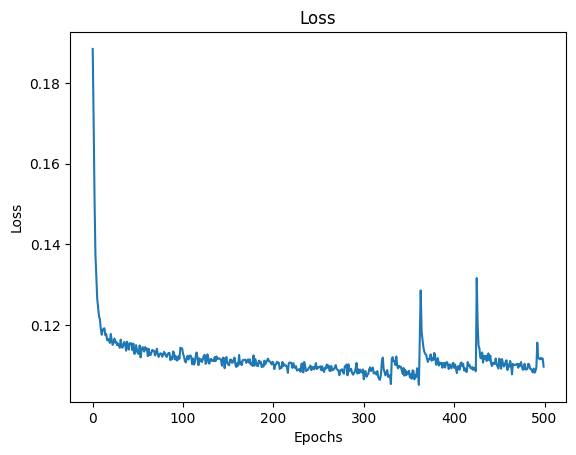

In [12]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

if not os.path.exists('.trained'):
    os.makedirs('.trained')

import datetime
now = datetime.datetime.now()
torch.save(model.state_dict(), f'.trained/{now.strftime("%Y-%m-%d_%H-%M-%S")}.pt')
torch.save(model.state_dict(), f'.trained/most_recent.pt')

In [13]:
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset

test_name = 'exitearth'

test_map = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data).to(device)

In [14]:
with torch.no_grad():
    replay_data = model(data).to('cpu').numpy()
    
replay_data = np.concatenate(replay_data)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + "exitearth" + '.npy', replay_data)

In [15]:
import osu.preview.preview as preview

preview.preview_replay(replay_data, test_map, test_song)